In [46]:
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

file_path = "Baseball Stats.xlsx" 
data = pd.read_excel(file_path, sheet_name=None)

batting_stats = data["Ohtani 2024 Reg S Batting Stats"]
swing_stats = data["Ohtani 2024 Reg S Swing Stats"] 

#columns for comparison
batting_cols = ['H', 'R', 'RBI']
swing_cols = ['EV (MPH)', 'LA (°)', 'Dist (ft)', 'Pitch (MPH)']  

#filter the columns
batting_data = batting_stats[batting_cols] 
swing_data = swing_stats[swing_cols]  

#fix data with missing values
batting_data = batting_data.dropna()
swing_data = swing_data.dropna()

#combine swing and batting data
aligned_data = pd.concat([batting_data.reset_index(drop=True), swing_data.reset_index(drop=True)], axis=1)

X = aligned_data[swing_cols]  #swing data is input
targets = {
    'Hits': aligned_data['H'],  #Hits
    'RBIs': aligned_data['RBI'],  #Runs Batted In
    'Runs': aligned_data['R']  #Runs 
}

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

results = {}

#to train and evaluate the models
for target_name, y in targets.items():
    #drop rows with missing values in the current target variable
    y = y.dropna()
    X_cleaned = X.loc[y.index] 
    X_scaled_cleaned = scaler.fit_transform(X_cleaned)

    #split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled_cleaned, y, test_size=0.2, random_state=42)

    #apply ElasticNet regression with cross-validation
    elastic_net = ElasticNetCV(
        cv=5, 
        random_state=42,
        l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0]  #range of l1 ratios
    )
    elastic_net.fit(X_train, y_train)  #fit the model to the training data

    #predict target values for the test set
    y_pred = elastic_net.predict(X_test)

    #evaluate the model using Mean Squared Error (MSE) and R-squared (R²) metrics
    mse = mean_squared_error(y_test, y_pred)  # Measures prediction error
    r2 = r2_score(y_test, y_pred)  # Measures how well the model explains the variance

    #get the coefficients
    coefficients = pd.DataFrame({
        'Swing Metric': swing_cols, 
        'Coefficient': elastic_net.coef_
    })

    results[target_name] = {
        'MSE': mse,
        'R²': r2,
        'Coefficients': coefficients.sort_values(by='Coefficient', ascending=False) 
    }

for target, result in results.items():
    print(f"Results for {target}:")
    print(result['Coefficients'])  # Display the importance of swing metrics
    print(f"Mean Squared Error (MSE): {result['MSE']}")  # Error metric
    print(f"R-squared (R²): {result['R²']}\n")  # Variance explanation


Results for Hits:
  Swing Metric  Coefficient
0     EV (MPH)         -0.0
1       LA (°)          0.0
2    Dist (ft)          0.0
3  Pitch (MPH)         -0.0
Mean Squared Error (MSE): 22.794755712202242
R-squared (R²): -0.0035700043152604444

Results for RBIs:
  Swing Metric   Coefficient
2    Dist (ft)  2.067064e-17
0     EV (MPH)  0.000000e+00
1       LA (°)  0.000000e+00
3  Pitch (MPH) -0.000000e+00
Mean Squared Error (MSE): 16.368929941122456
R-squared (R²): -0.00013123741741871697

Results for Runs:
  Swing Metric  Coefficient
0     EV (MPH)         -0.0
1       LA (°)          0.0
2    Dist (ft)          0.0
3  Pitch (MPH)         -0.0
Mean Squared Error (MSE): 18.76558701993194
R-squared (R²): -8.571908598486999e-07



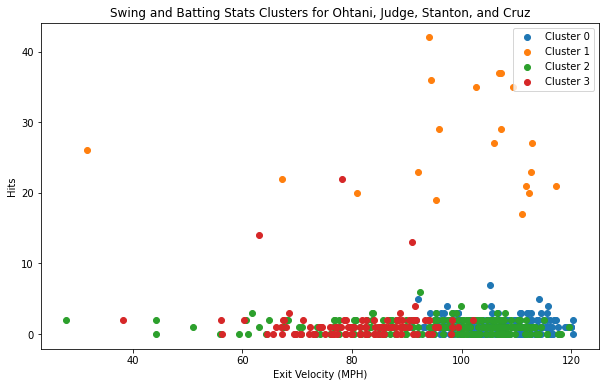

Cluster Summary:
Player   Cruz  Judge  Ohtani  Stanton
Cluster                              
0          45     82      60       48
1           4      6       6        4
2          78     54      52       51
3          26     23      48       18
Cluster Centroids:
     EV (MPH)     LA (°)   Dist (ft)  Pitch (MPH)          H          R  \
0  106.947660  23.868085  341.672340    89.758723   1.200000   0.791489   
1   98.435000  18.300000  240.200000    90.495000  27.300000  17.100000   
2   95.594468  -9.068085   44.391489    90.428511   1.038298   0.574468   
3   81.660000  35.260870  199.400000    88.720000   1.356522   0.791304   

         RBI  
0   0.753191  
1  19.500000  
2   0.744681  
3   0.886957  


In [47]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

file_path = "Baseball Stats.xlsx"  
data = pd.read_excel(file_path, sheet_name=None) 

players = {
    "Ohtani": {
        "Swing Stats": data["Ohtani 2024 Reg S Swing Stats"], 
        "Batting Stats": data["Ohtani 2024 Reg S Batting Stats"] 
    },
    "Judge": {
        "Swing Stats": data["Judge 2024 Reg S Swing Stats"], 
        "Batting Stats": data["Judge 2024 Reg S Batting Stats"]  
    },
    "Stanton": {
        "Swing Stats": data["Stanton 2024 Reg S Swing Stats"],  
        "Batting Stats": data["Stanton 2024 Reg S Batting Stat"] 
    },
    "Cruz": {
        "Swing Stats": data["Cruz 2024 Reg S Swing Stats"], 
        "Batting Stats": data["Cruz 2024 Reg S Batting Stats"] 
    }
}

#columns for comparison
swing_cols = ['EV (MPH)', 'LA (°)', 'Dist (ft)', 'Pitch (MPH)']  #swing data
batting_cols = ['H', 'R', 'RBI']  #batting data

all_combined_stats = []
player_labels = [] 

#loop through each player's data
for player, stats in players.items():
    swing_stats = stats["Swing Stats"][swing_cols].dropna()  #clean swing stats
    batting_stats = stats["Batting Stats"][batting_cols].dropna()  #clean batting stats
    
    #make data same size
    min_len = min(len(swing_stats), len(batting_stats))
    #trim to same size
    swing_stats = swing_stats.iloc[:min_len]  
    batting_stats = batting_stats.iloc[:min_len]  
    
    #combine stats to single set
    combined_stats = pd.concat([swing_stats.reset_index(drop=True), 
    batting_stats.reset_index(drop=True)], axis=1)
    all_combined_stats.append(combined_stats)  
    player_labels.extend([player] * len(combined_stats))

#combine all data
combined_data = pd.concat(all_combined_stats, axis=0).reset_index(drop=True)

#handle missing or infinite values in the data
combined_data = combined_data.replace([float('inf'), -float('inf')], np.nan).dropna()

scaler = StandardScaler()
combined_data_scaled = scaler.fit_transform(combined_data)

#apply KMeans clustering to the standardized data
kmeans = KMeans(n_clusters=4, random_state=42)  # Define 4 clusters
kmeans.fit(combined_data_scaled)  # Fit the clustering model

combined_data['Cluster'] = kmeans.labels_ 
combined_data['Player'] = player_labels  

#summarize clusters by counting points per player in each cluster
cluster_summary = combined_data.groupby(['Cluster', 'Player']).size().unstack(fill_value=0)

#visualize clusters 
plt.figure(figsize=(10, 6)) 
for cluster in range(4):  
    cluster_points = combined_data[combined_data['Cluster'] == cluster]  
    plt.scatter(cluster_points['EV (MPH)'], cluster_points['H'], label=f'Cluster {cluster}')  

#labels
plt.xlabel('Exit Velocity (MPH)')
plt.ylabel('Hits')
plt.title('Swing and Batting Stats Clusters for Ohtani, Judge, Stanton, and Cruz')
plt.legend()
plt.show()  # Display the plot

print("Cluster Summary:")
print(cluster_summary)  

centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=combined_data.columns[:-2])
print("Cluster Centroids:")
print(centroids)


Classification Report:
              precision    recall  f1-score   support

     Dodgers       0.29      0.67      0.40         3
     Yankees       0.50      0.17      0.25         6

    accuracy                           0.33         9
   macro avg       0.39      0.42      0.33         9
weighted avg       0.43      0.33      0.30         9



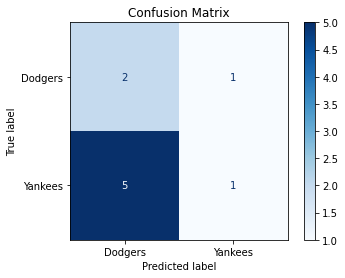

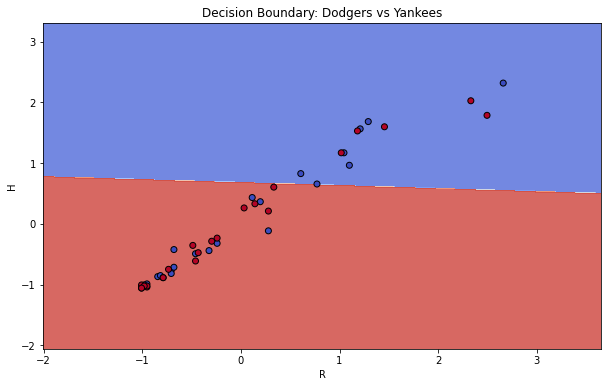

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

file_path = "Baseball Stats.xlsx"  # Replace with your uploaded file name
data = pd.read_excel(file_path, sheet_name=None)

dodgers_stats = data["Dodgers 2024 Reg S Stats"]
yankees_stats = data["Yankees 2024 Reg S Stats"]

dodgers_stats['Team'] = 'Dodgers'
yankees_stats['Team'] = 'Yankees'

#combine the data for both teams
combined_stats = pd.concat([dodgers_stats, yankees_stats], axis=0).reset_index(drop=True)

features = ['R', 'H', 'HR', 'RBI', 'SB']  #Runs, Hits, Home Runs, RBIs, Stolen Bases
target = 'Team'

X = combined_stats[features]
y = combined_stats[target]

y = y.map({'Dodgers': 0, 'Yankees': 1})

X = X.dropna()
y = y.loc[X.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#train a Linear Support Vector Classifier
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

#predict on the test set
y_pred = svc.predict(X_test)

#evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Dodgers', 'Yankees']))

#visualize
from sklearn.metrics import confusion_matrix

#generate
cm = confusion_matrix(y_test, y_pred)

#plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dodgers', 'Yankees'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


#visualize decision bpundary
plt.figure(figsize=(10, 6))
X_2D = X_scaled[:, :2]
svc_2D = SVC(kernel='linear', random_state=42).fit(X_2D, y)

#meshgrid for the decision boundary
x_min, x_max = X_2D[:, 0].min() - 1, X_2D[:, 0].max() + 1
y_min, y_max = X_2D[:, 1].min() - 1, X_2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = svc_2D.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Decision Boundary: Dodgers vs Yankees')
plt.show()


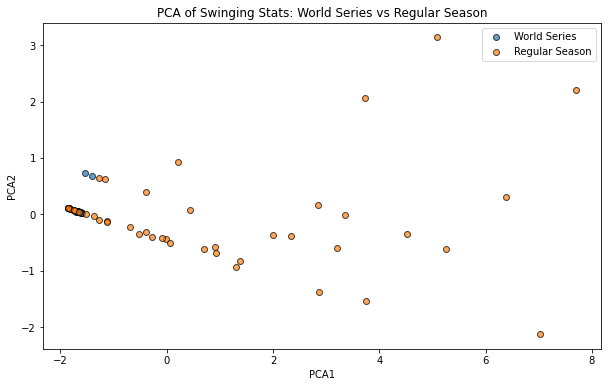

Variance by PCA1: 0.86
Variance by PCA2: 0.08


In [51]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

file_path = "Baseball Stats.xlsx" 
data = pd.read_excel(file_path, sheet_name=None)

dodgers_ws_stats = data["Dodgers 2024 WS Stats"]
dodgers_reg_stats = data["Dodgers 2024 Reg S Stats"]
yankees_ws_stats = data["Yankees 2024 WS Stats"]
yankees_reg_stats = data["Yankees 2024 Reg S Stats"]

dodgers_ws_stats['Game Type'] = 'World Series'
dodgers_reg_stats['Game Type'] = 'Regular Season'
yankees_ws_stats['Game Type'] = 'World Series'
yankees_reg_stats['Game Type'] = 'Regular Season'

#combine the data into one dataset
dodgers_stats = pd.concat([dodgers_ws_stats, dodgers_reg_stats], axis=0)
yankees_stats = pd.concat([yankees_ws_stats, yankees_reg_stats], axis=0)
combined_stats = pd.concat([dodgers_stats, yankees_stats], axis=0).reset_index(drop=True)

#get specific data types
swinging_stats_cols = ['AB', 'H', '2B', '3B', 'HR', 'SO', 'BB']
X = combined_stats[swinging_stats_cols]
#specifiy by game type
y = combined_stats['Game Type']  

#handle missing values by dropping invalid rows
X = X.dropna()
y = y.loc[X.index]

#standardize the swinging stats
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#apply Randomized PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

#add the PCA components to a DataFrame for visualization
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Game Type'] = y.values

#visualize results
plt.figure(figsize=(10, 6))
for game_type, color in zip(['World Series', 'Regular Season'], ['red', 'blue']):
    subset = pca_df[pca_df['Game Type'] == game_type]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=game_type, alpha=0.7, edgecolors='k')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of Swinging Stats: World Series vs Regular Season')
plt.legend()
plt.show()


explained_variance = pca.explained_variance_ratio_
print(f"Variance by PCA1: {explained_variance[0]:.2f}")
print(f"Variance by PCA2: {explained_variance[1]:.2f}")


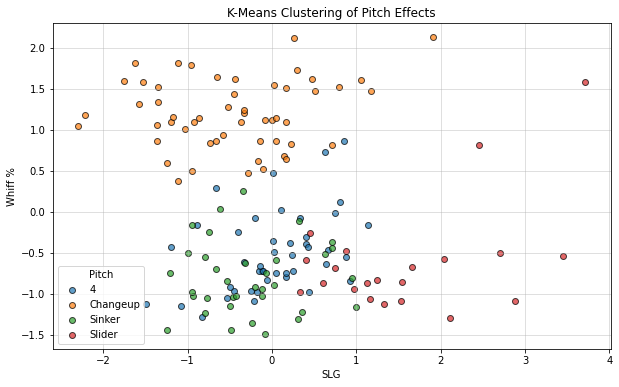

In [55]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

file_path = "Baseball Stats.xlsx"
data = pd.read_excel(file_path, sheet_name="Pitch Stats")


#select features and drop invalid values
features = ['SLG', 'Whiff %', 'K%', 'Put Away %', 'Hard Hit %']
X = filtered_data[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

#map clusters back to pitch types
cluster_map = {
    0: '4',
    1: 'Changeup',
    2: 'Sinker',
    3: 'Slider'
}

#add clusters and pitch type predictions to the data
filtered_data['Cluster'] = clusters
filtered_data['Predicted Pitch Type'] = filtered_data['Cluster'].map(cluster_map)

#visualize the clustering results with a legend
plt.figure(figsize=(10, 6))

for cluster in range(kmeans.n_clusters):
    subset = X_scaled[clusters == cluster, :]
    plt.scatter(
        subset[:, 0], subset[:, 1],  
        label=f"{cluster_map.get(cluster, f'Cluster {cluster}')}",
        alpha=0.7, edgecolor='k'
    )

plt.xlabel(features[0])  
plt.ylabel(features[1])
plt.title("K-Means Clustering of Pitch Effects")
plt.legend(title="Pitch", loc="best")
plt.grid(alpha=0.5)
plt.show()
